In [36]:
import geopandas
import requests
import datetime
import calendar

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from zipfile import ZipFile
from urllib.request import urlopen
from io import BytesIO

In [37]:
def url_generator(lat, lon, date):
    url = f'https://api.sunrisesunset.io/json?lat={str(lat)}&lng={str(lon)}&timezone=UTC&date={date}'
    return url

In [38]:
def get_tr_city_cp(city):
    humdata_url = 'https://data.humdata.org/dataset/ac768a5c-db29-4872-9792-bd3179e29c45/resource/b1d18b54-7175-4d32-85e9-a4710509dbfb/download/turkey_centeralpoints_1_2.zip'
    turkey_centeralpoints = geopandas.read_file(humdata_url)[['adm1_en', 'latitude', 'longitude']]
    turkey_centeralpoints = turkey_centeralpoints.rename(columns={'adm1_en': 'city'})
    
    [lat, long] = turkey_centeralpoints[turkey_centeralpoints['city'] == city][['latitude', 'longitude']].iloc[0]

    return lat, long

In [39]:
# converts time to minutes 
def total_mins(time):
    s = datetime.timedelta(hours = time.hour,
                            minutes = time.minute)
    mins = s.total_seconds() / 60
    return mins

In [40]:
def get_sunset_sunrise(city):
    df = pd.DataFrame(columns = ['date', 'sunrise', 'sunset', 'solar_noon', 'sunrise(minutes)', 'sunset(minutes)', 'solar_noon(minutes)'])

    city_lat, city_long = get_tr_city_cp(city)
    start_date = datetime.date(2022, 1, 1)
    end_date = datetime.date(2022, 12, 31)

    delta = datetime.timedelta(days=1)
    while (start_date <= end_date):
        date_url = url_generator(city_lat, city_long, f'{start_date.year}-{start_date.month}-{start_date.day}')
        req = requests.get(date_url).json()['results']

        sunrise = req['sunrise']
        sunset = req['sunset']
        solarnoon = req['solar_noon']

        date = datetime.datetime(start_date.year, start_date.month, start_date.day)
        sunrise = datetime.datetime.strptime(sunrise[:-3], '%H:%M:%S') 
        sunset = datetime.datetime.strptime(sunset[:-3], '%H:%M:%S')
        solarnoon = datetime.datetime.strptime(solarnoon[:-3], '%H:%M:%S')

        sunrise += datetime.timedelta(hours=3)
        sunset += datetime.timedelta(hours=12+3)
        solarnoon += datetime.timedelta(hours=3)

        sunrise_mins = total_mins(sunrise)
        sunset_mins = total_mins(sunset)
        solarnoon_mins = total_mins(solarnoon)

        new_row = pd.DataFrame([[date, sunrise, sunset, solarnoon, sunrise_mins, sunset_mins, solarnoon_mins]],
                            columns=['date', 'sunrise', 'sunset', 'solar_noon', 'sunrise(minutes)', 'sunset(minutes)', 'solar_noon(minutes)'])

        df = pd.concat([df, new_row])

        start_date += delta

    return df

In [41]:
def plot_sunrise_sunset(city, ax):
    df = get_sunset_sunrise(city)

    ax.plot(np.arange(0, 365), df['sunrise(minutes)'], label='sunrise')
    ax.plot(np.arange(0, 365), df['sunset(minutes)'], label='sunset')
    ax.plot(np.arange(0, 365), df['solar_noon(minutes)'], label='solar_noon')
    ax.axhline(y=8*60, color='red', linewidth=3, label='08:00')

    ax.grid()

    ax.set_ylabel('Time')
    ax.set_title(city)
    ax.legend()

    ax.set_xticks(np.arange(0, 365, step=31))
    ax.set_xticklabels(calendar.month_name[1:], rotation=30)

    ax.set_yticks(np.arange(0, 24*60, step=60*2))
    ax.set_yticklabels(np.arange(0, 24, step=2))

### In 2016 Turkey decided to remain permanently in the summertime zone. Which time zone is better for Turkey (summer or winter)?

### Turkey Population Density Map

In [42]:
tuik_url = 'https://data.tuik.gov.tr/Bulten/DownloadIstatistikselTablo?p=OW4kk4KIauRVHwQK9tma/jlD055DCNYc4XuRAZwpy550wSt7B4cANX305nVsp//V'
tuik_pop = pd.read_excel(tuik_url)

In [43]:
turkey_2021_pop = tuik_pop.iloc[4:85, [0, 22]].reset_index(drop = True)
turkey_2021_pop.columns = ['city', 'population']

In [44]:
turkey_2021_pop['city'] = turkey_2021_pop['city'].apply(lambda city : city.upper())
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('Ç', 'C')
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('Ğ', 'G')
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('İ', 'I')
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('Ö', 'O')
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('Ş', 'S')
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('Ü', 'U')

In [45]:
humdata_url1 = 'https://data.humdata.org/dataset/ac768a5c-db29-4872-9792-bd3179e29c45/resource/6cc83f12-885f-475b-98f7-9bad99d682b9/download/turkey_administrativelevels0_1_2.zip'
turkey_adm = geopandas.read_file(humdata_url1)[['adm1_en', 'geometry']]
turkey_adm = turkey_adm.rename(columns={'adm1_en': 'city'})

In [46]:
turkey_pop_geo = pd.merge(turkey_adm, turkey_2021_pop)

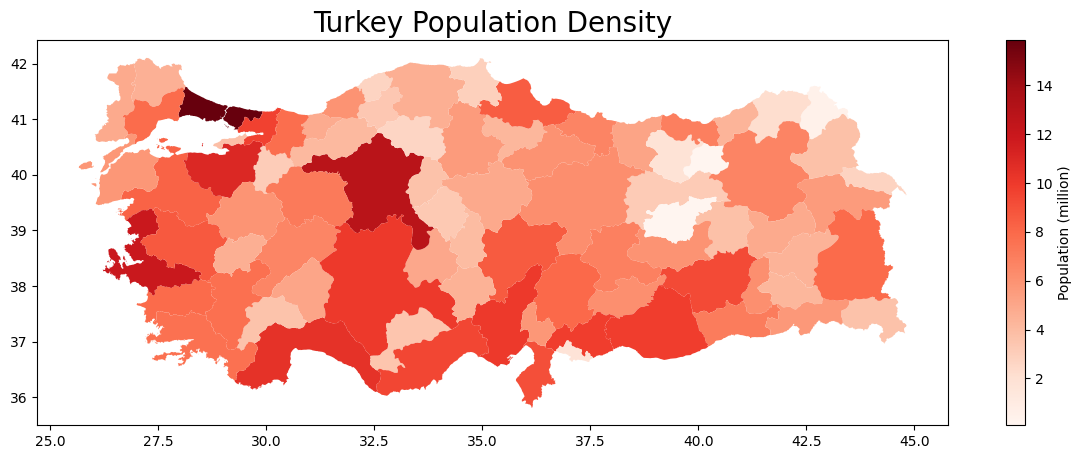

In [47]:
turkey_pop_geo['population(log())'] = np.log(turkey_pop_geo['population'])

fig, ax = plt.subplots(figsize=(15,5))
ax.set_title("Turkey Population Density", size=20)
turkey_pop_geo.plot(column="population(log())", cmap="Reds", ax=ax)
n = colors.Normalize(turkey_pop_geo.population.min()/1000000, turkey_pop_geo.population.max()/1000000)
cbar = plt.cm.ScalarMappable(norm=n, cmap="Reds")
ax_cbar = fig.colorbar(cbar, ax=ax)
ax_cbar.set_label("Population (million)")

### Turkey's Population Density Point

In [48]:
humdata_url2 = 'https://data.humdata.org/dataset/ac768a5c-db29-4872-9792-bd3179e29c45/resource/b1d18b54-7175-4d32-85e9-a4710509dbfb/download/turkey_centeralpoints_1_2.zip'
turkey_centeralpoints = geopandas.read_file(humdata_url2)[['adm1_en', 'latitude', 'longitude']]
turkey_centeralpoints = turkey_centeralpoints.rename(columns={'adm1_en': 'city'})

In [49]:
turkey_pop_lot_long = pd.merge(turkey_centeralpoints, turkey_2021_pop)

In [50]:
turkey_total_pop = turkey_2021_pop['population'].sum()

In [51]:
pop_cp_lat = np.sum(turkey_pop_lot_long['latitude']*turkey_pop_lot_long['population'])/turkey_total_pop
pop_cp_long = np.sum(turkey_pop_lot_long['longitude']*turkey_pop_lot_long['population'])/turkey_total_pop

df = pd.DataFrame({'latitude': [pop_cp_lat],'longitude': [pop_cp_long]})

pop_cp = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.longitude, df.latitude))

In [52]:
geo_cp_lat = (min(turkey_pop_lot_long['latitude']) + max(turkey_pop_lot_long['latitude'])) / 2
geo_cp_long = (min(turkey_pop_lot_long['longitude']) + max(turkey_pop_lot_long['longitude'])) / 2

df = pd.DataFrame({'latitude': [geo_cp_lat],'longitude': [geo_cp_long]})

geo_cp = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.longitude, df.latitude))

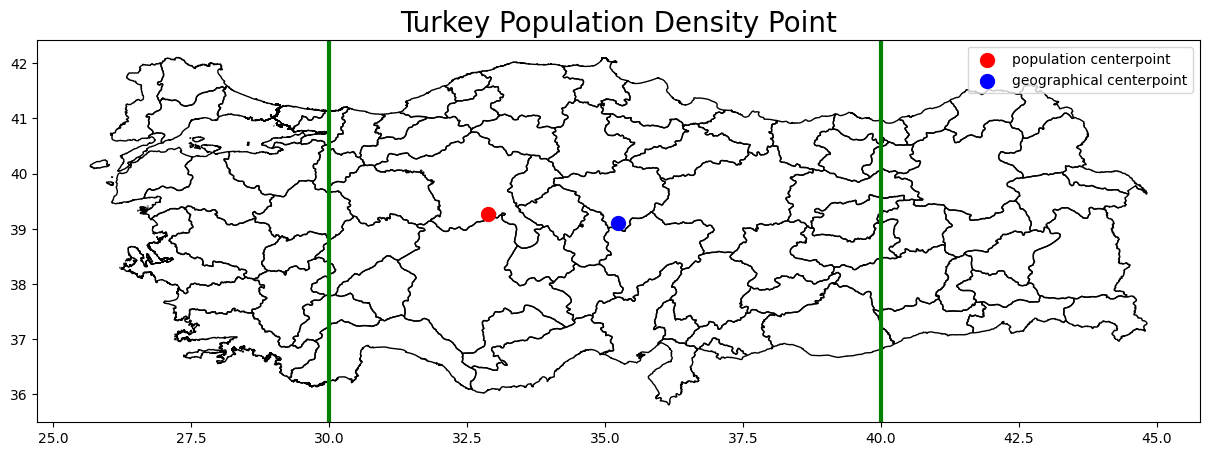

In [53]:
fig, ax = plt.subplots(figsize=(15, 15))

turkey_adm.plot(ax = ax,edgecolor="k", facecolor="none")
pop_cp.plot(ax = ax, color='red', markersize = 100, label='population centerpoint')
geo_cp.plot(ax = ax, color='blue', markersize = 100, label='geographical centerpoint')
ax.axvline(x=30, color='green', linewidth=3)
ax.axvline(x=40, color='green', linewidth=3)

ax.set_title("Turkey Population Density Point", size=20)
ax.legend()

plt.show()

### Which cities are worst affected by the permanent summertime in Turkey?

longitude a baktigimizda 40 meridyenine en uzak olanlar en kotu etkileniyor diyebiliriz

In [54]:
turkey_centeralpoints['cpDistanceMeridian40'] = abs(turkey_centeralpoints['longitude']-40)

Top 5 most affected cities:

In [55]:
turkey_centeralpoints.sort_values(by='cpDistanceMeridian40', ascending=False)[:5]

,city,latitude,longitude,cpDistanceMeridian40
21,CANAKKALE,40.146498,26.406294,13.593706
27,EDIRNE,41.676425,26.552412,13.447588
40,IZMIR,38.434144,27.171866,12.828134
49,KIRKLARELI,41.735924,27.218857,12.781143
55,MANISA,38.622270,27.433657,12.566343


In [56]:
affected_df = pd.merge(turkey_adm, turkey_centeralpoints)

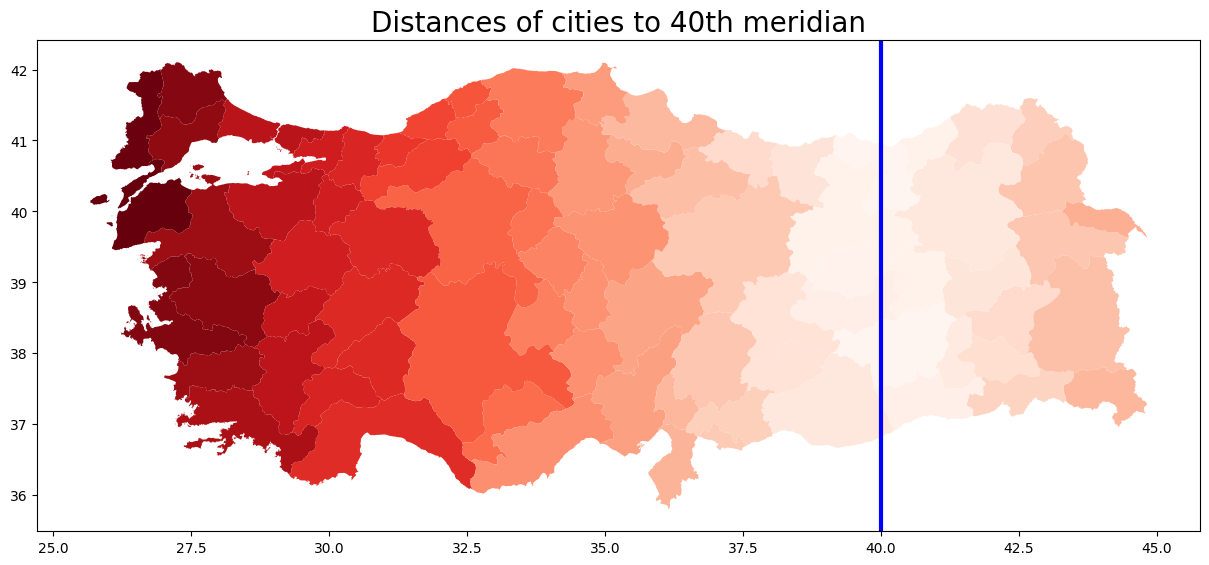

In [57]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Distances of cities to 40th meridian", size=20)
affected_df.plot(column='cpDistanceMeridian40', cmap="Reds", ax=ax)
ax.axvline(x=40, color='blue', linewidth=3)

### Preliminary results of the public consultation on time change in Europe (2018)

In [58]:
results = pd.DataFrame([['Austria', 0.77],
                        ['Belgium', 0.84],
                        ['Bulgaria', 0.84],
                        ['Croatia', 0.90],
                        ['Cyprus', 0.47],
                        ['Czechia', 0.83],
                        ['Denmark', 0.81],
                        ['Estonia', 0.85],
                        ['Finland', 0.95],
                        ['France', 0.84],
                        ['Germany', 0.84],
                        ['Greece', 0.44],
                        ['Hungary', 0.90],
                        ['Ireland', 0.88],
                        ['Italy', 0.66],
                        ['Latvia', 0.85],
                        ['Lithuania', 0.91],
                        ['Luxembourg', 0.79],
                        ['Malta', 0.54],
                        ['Netherlands', 0.79],
                        ['Poland', 0.95],
                        ['Portugal', 0.85],
                        ['Romania', 0.78],
                        ['Slovakia', 0.80],
                        ['Slovenia', 0.87],
                        ['Spain', 0.93],
                        ['Sweden', 0.88],
                        ['United Kingdom', 0.82]],
                        columns = ['country', 'abolish'])
results['keep'] = (1-results['abolish'])*100
results['abolish'] = results['abolish']*100



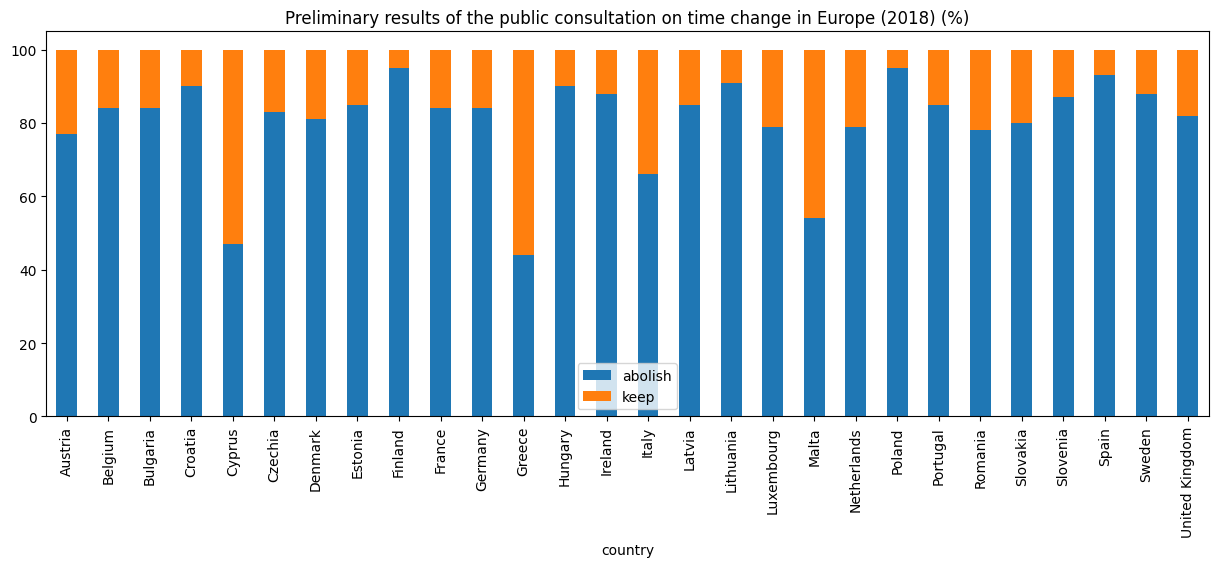

In [59]:
results.plot.bar(x = 'country', stacked='true', title='Preliminary results of the public consultation on time change in Europe (2018) (%)', figsize=(15, 5))
plt.show()

## Sunrise and Sunset Times for Cities in Turkey

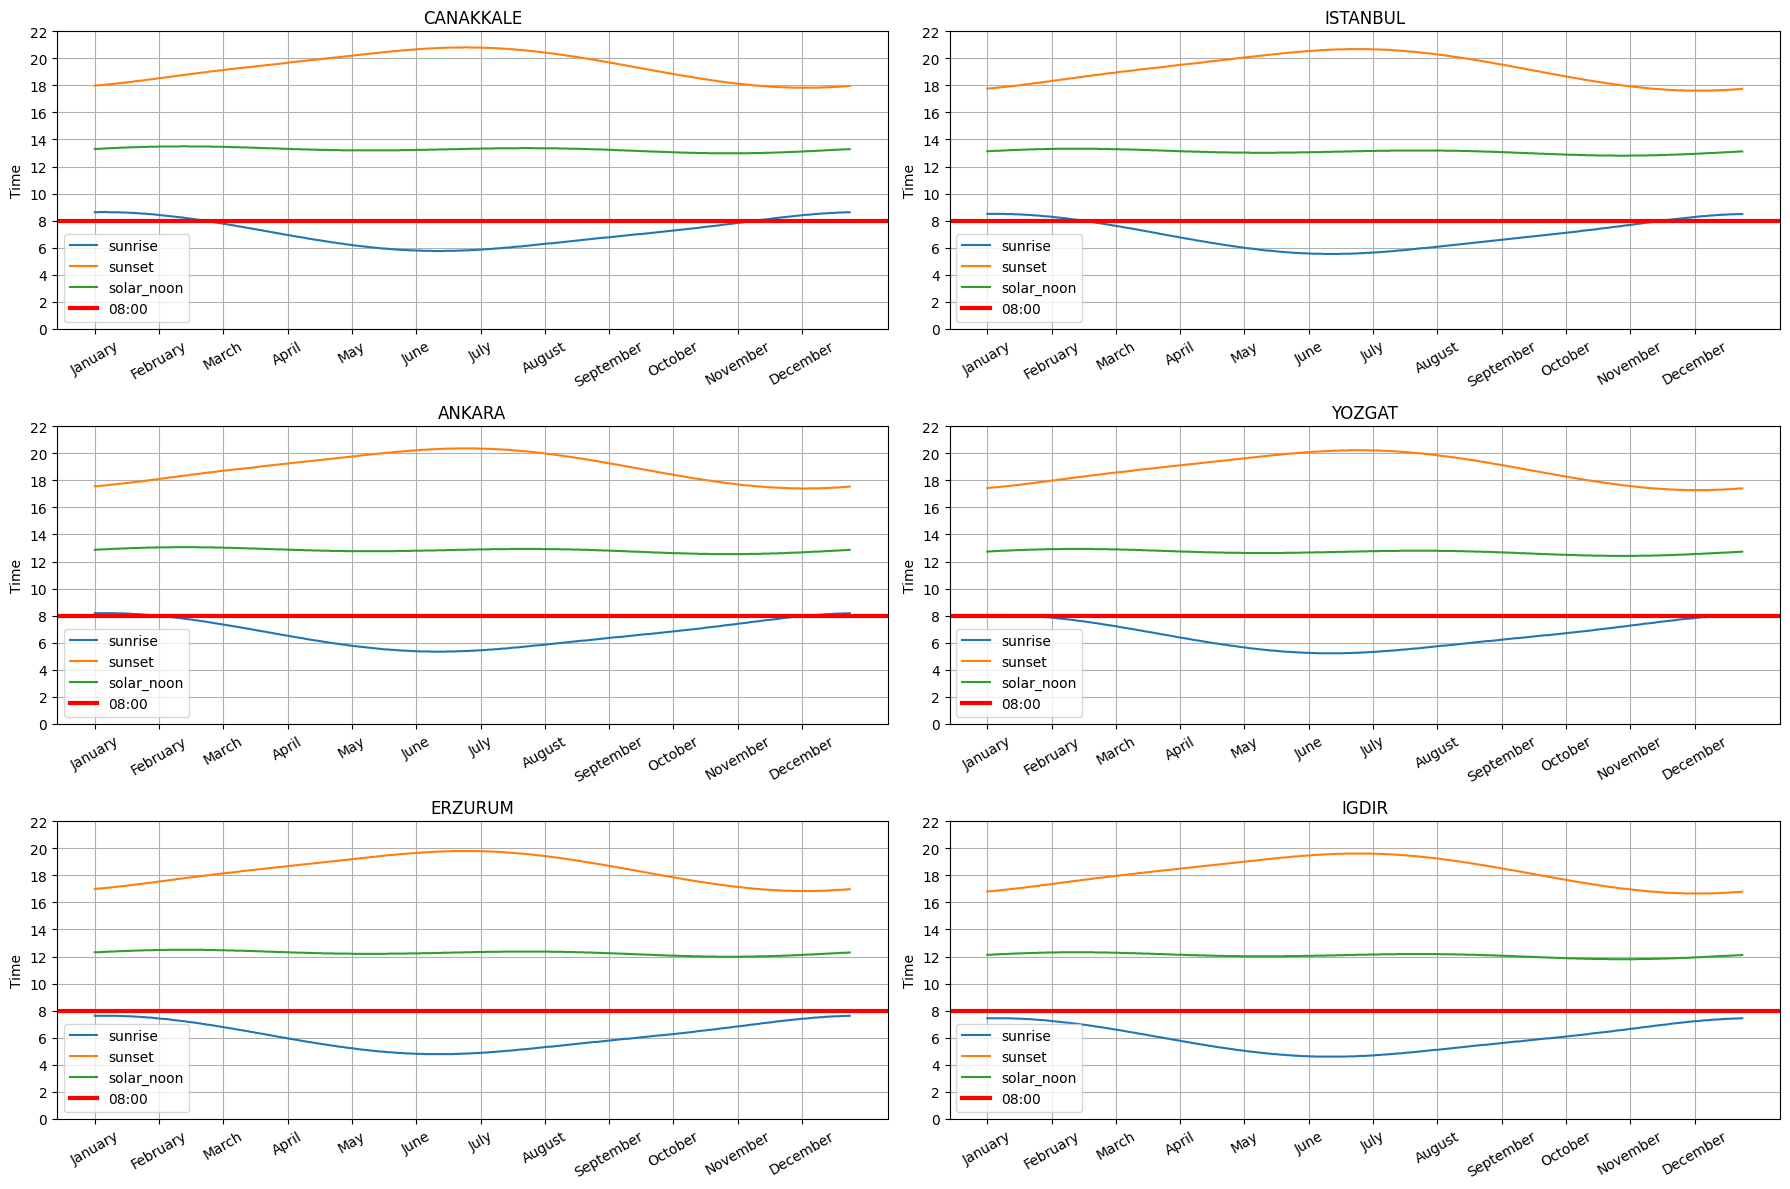

In [63]:
cities = ['CANAKKALE', 'ISTANBUL', 'ANKARA', 'YOZGAT', 'ERZURUM', 'IGDIR']
x, y = 0, 0

fig, axs = plt.subplots(3, 2, figsize=(18,12))

for city in cities:
    if(y==2):
        y=0
        x+=1
    plot_sunrise_sunset(city, axs[x, y])
    y += 1

fig.tight_layout()

plt.show()